In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import talib
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


In [2]:
#loading the file Historical_series.xlsx

xls = pd.ExcelFile("Historical_series.xlsx")

#define the function to count the sequence of positive returns

def positivecounter(df):
    counter = []
    index = 0
    for i in df['pos_string']:
        if i == 1:
            index = index + 1
            counter.append(index)
        else:
            index = 0
            counter.append(index)
    df['count_pos_string'] = counter  

# IBM

In [3]:
IBM = pd.read_excel(xls, "IBM", header=None).drop([0])
new_header=IBM.iloc[0]
IBM.columns=new_header
IBM=IBM[1:]
IBM=IBM.reset_index(drop=True)
IBM = IBM.loc[:, IBM.columns.notna()]
IBM = IBM.T.drop_duplicates().T
#GLD = GLD.iloc[:,0:4]
IBM.columns = ['Date', 'AdjClose', 'avg10', 'avg50']

ticker = 'IBM'
period1 = int(time.mktime(datetime.datetime(1999, 12, 31, 23, 59).timetuple())) #year,month,day,hour,minute
period2 = int(time.mktime(datetime.datetime(2022, 2, 11, 23, 59).timetuple()))
interval = '1d' # 1d, 1m, 1wk

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
ibmy = pd.read_csv(query_string)

ibmy = ibmy.dropna()
ibmy['Date'] = pd.to_datetime(ibmy['Date'])

IBM_final = pd.merge(IBM,ibmy,on='Date')

IBM_final["SPD_OPEN/CLOSE"] = (
    IBM_final["Close"] - IBM_final["Open"]
    )
IBM_final["SPD_HIGH/LOW"] = (
    IBM_final["High"] - IBM_final["Low"]
    )

#calculate the %ADJclose price variation of IBM stock

for i in IBM_final["AdjClose"]:
    IBM_final["Adj_Close_Returns"] = IBM_final["AdjClose"].pct_change()*100

for i in IBM_final["Close"]:
    IBM_final["Close_Returns"] = IBM_final["Close"].pct_change()*100

IBM_final['Log_Returns'] = np.log(IBM_final['AdjClose'].astype('float64')/IBM_final['AdjClose'].astype('float64').shift(1))


pd.to_datetime(IBM_final["Date"])
IBM_final=IBM_final.set_index("Date")

IBM_final['avg7'] = IBM_final["AdjClose"].rolling(window =7).mean()
IBM_final["avg10"] = IBM_final["AdjClose"].rolling(window =10).mean()
IBM_final["avg50"] = IBM_final["AdjClose"].rolling(window =50).mean()
IBM_final['avg100'] = IBM_final["AdjClose"].rolling(window =100).mean()
IBM_final["avg200"] = IBM_final["AdjClose"].rolling(window =200).mean()
IBM_final['avg253'] = IBM_final["AdjClose"].rolling(window =253).mean()

#POSITIVE AND NEGATIVE COUNTING 

pos_count_IBM, neg_count_IBM = 0, 0
  
# iterating each number in list
for num in IBM_final["Adj_Close_Returns"]:
      
    # checking condition
    if num >= 0:
        pos_count_IBM += 1
  
    else:
        neg_count_IBM += 1
          
print("Positive closing IBM: ", pos_count_IBM)
print("Negative closing IBM: ", neg_count_IBM)

Positive closing IBM:  2854
Negative closing IBM:  2712


In [4]:
#AdjClose to BINARY

positive_string_IBM = []

for i in IBM_final["Adj_Close_Returns"]:
    if i > 0:
        positive_string_IBM.append(1)
    else:
        positive_string_IBM.append(0)
        
IBM_final["pos_string"] = positive_string_IBM

IBM_final = IBM_final.fillna(0)

IBM_final = IBM_final[['AdjClose','Open','High','Low','Close','Volume','avg7','avg10','avg50','avg100','avg200','avg253','SPD_OPEN/CLOSE','SPD_HIGH/LOW', "Adj_Close_Returns",'Close_Returns','Log_Returns','pos_string']]

IBM_final['direction'] = np.sign(IBM_final['Adj_Close_Returns']).astype(int)

positivecounter(IBM_final)

IBM_final


,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,avg200,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string
Date,,,,,,,,,,,,,,,,,,,,
1999-12-31,61.780476,104.385757,104.684509,101.935944,103.130974,3002334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.254783,2.748565,0.000000,0.000000,0.000000,0,0,0
2000-01-03,66.433693,107.492828,110.898659,106.955070,110.898659,10823694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.405831,3.943589,7.531857,7.531864,0.072617,1,1,1
2000-01-04,64.178642,108.986618,109.464630,105.999046,107.134323,8606279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.852295,3.465584,-3.394438,-3.394393,-0.034534,0,-1,0
2000-01-05,66.433693,107.970840,114.483749,107.194077,110.898659,13318927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.927819,7.289672,3.513709,3.513660,0.034534,1,1,1
2000-01-06,65.288307,112.810707,113.706978,108.508606,108.986618,8338607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.824089,5.198372,-1.724104,-1.724134,-0.017391,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,135.606552,137.449997,137.820007,136.270004,137.240005,3759000,134.525286,133.976187,128.115187,126.085076,129.005488,126.527303,-0.209992,1.550003,0.065632,0.065630,0.000656,1,1,1
2022-02-08,135.389175,137.229996,137.520004,135.779999,137.020004,4181800,134.881003,134.067093,128.534338,126.167161,129.037291,126.623015,-0.209992,1.740005,-0.160300,-0.160304,-0.001604,0,-1,0
2022-02-09,136.149994,137.839996,138.350006,136.830002,137.789993,5393500,135.476682,134.415891,128.915546,126.268040,129.070894,126.721302,-0.050003,1.520004,0.561949,0.561954,0.005604,1,1,1


In [5]:
worst_IBM = IBM_final["Adj_Close_Returns"].loc["2010-01":"2015-01"].idxmin() #direi di fare cosi per diversi periodi di tempo per individuare i massimi e i minimi da sfruttare
best_IBM = IBM_final["Adj_Close_Returns"].idxmax()

std_IBM = IBM_final["Adj_Close_Returns"].std() 
avg_IBM = IBM_final["Adj_Close_Returns"].mean()

# NASDAQ

In [6]:
NASDAQ = pd.read_excel(xls, "Nasdaq", header=None).drop([0])
new_header=NASDAQ.iloc[0]
NASDAQ.columns=new_header
NASDAQ=NASDAQ[1:]
NASDAQ=NASDAQ.reset_index(drop=True)
NASDAQ = NASDAQ.loc[:, NASDAQ.columns.notna()]
NASDAQ = NASDAQ.T.drop_duplicates().T
NASDAQ.columns = ['Date', 'AdjClose', 'avg10', 'avg50']

#Download gold daily data from yahoo database

ticker = '^IXIC'
period1 = int(time.mktime(datetime.datetime(1999, 12, 31, 23, 59).timetuple())) #year,month,day,hour,minute
period2 = int(time.mktime(datetime.datetime(2022, 2, 11, 23, 59).timetuple()))
interval = '1d' # 1d, 1m, 1wk

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

nsdqy = pd.read_csv(query_string)

#Clean goldy dataset

nsdqy = nsdqy.dropna()
nsdqy['Date'] = pd.to_datetime(nsdqy['Date'])

NASDAQ_final = pd.merge(NASDAQ,nsdqy,on='Date')

NASDAQ_final["SPD_OPEN/CLOSE"] = (
    NASDAQ_final["Close"] - NASDAQ_final["Open"]
    )
NASDAQ_final["SPD_HIGH/LOW"] = (
    NASDAQ_final["High"] - NASDAQ_final["Low"]
    )

#calculate the %price variation of NASDAQ stock
for i in NASDAQ_final["AdjClose"]:
    NASDAQ_final["Adj_Close_Returns"] = NASDAQ_final["AdjClose"].pct_change()*100

for i in NASDAQ_final["Close"]:
    NASDAQ_final["Close_Returns"] = NASDAQ_final["Close"].pct_change()*100

NASDAQ_final['Log_Returns'] = np.log(NASDAQ_final['AdjClose'].astype('float64')/NASDAQ_final['AdjClose'].astype('float64').shift(1))

pd.to_datetime(NASDAQ_final["Date"])
NASDAQ_final=NASDAQ_final.set_index("Date")


NASDAQ_final["avg7"] = NASDAQ_final["AdjClose"].rolling(window =7).mean()
NASDAQ_final["avg10"] = NASDAQ_final["AdjClose"].rolling(window =10).mean()
NASDAQ_final["avg50"] = NASDAQ_final["AdjClose"].rolling(window =50).mean()
NASDAQ_final["avg100"] = NASDAQ_final["AdjClose"].rolling(window =100).mean()
NASDAQ_final["avg200"] = NASDAQ_final["AdjClose"].rolling(window =200).mean()
NASDAQ_final["avg253"] = NASDAQ_final["AdjClose"].rolling(window =253).mean()

#POSITIVE AND NEGATIVE COUNTING 

pos_count_NASDAQ, neg_count_NASDAQ = 0, 0
  
# iterating each number in list
for num in NASDAQ_final["Adj_Close_Returns"]:
      
    # checking condition
    if num >= 0:
        pos_count_NASDAQ += 1
  
    else:
        neg_count_NASDAQ += 1
          
print("Positive closing IBM: ", pos_count_NASDAQ)
print("Negative closing IBM: ", neg_count_NASDAQ)

Positive closing IBM:  3030
Negative closing IBM:  2536


In [7]:
positive_string_NASDAQ = []

for i in NASDAQ_final["Adj_Close_Returns"]:
    if i > 0:
        positive_string_NASDAQ.append(1)
    else:
        positive_string_NASDAQ.append(0)
        
NASDAQ_final["pos_string"] = positive_string_NASDAQ

NASDAQ_final = NASDAQ_final.fillna(0)

NASDAQ_final = NASDAQ_final[['AdjClose','Open','High','Low','Close','Volume','avg7','avg10','avg50','avg100','avg200','avg253','SPD_OPEN/CLOSE','SPD_HIGH/LOW', "Adj_Close_Returns",'Close_Returns','Log_Returns' ,'pos_string']]

NASDAQ_final['direction'] = np.sign(NASDAQ_final['Adj_Close_Returns']).astype(int)

positivecounter(NASDAQ_final)

NASDAQ_final

,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,avg200,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string
Date,,,,,,,,,,,,,,,,,,,,
1999-12-31,4069.310059,4056.989990,4082.370117,4032.330078,4069.310059,762980000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.320069,50.040039,0.000000,0.000000,0.000000,0,0,0
2000-01-03,4131.149902,4186.189941,4192.189941,3989.709961,4131.149902,1510070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-55.040039,202.479980,1.519664,1.519664,0.015082,1,1,1
2000-01-04,3901.689941,4020.000000,4073.250000,3898.229980,3901.689941,1511840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-118.310059,175.020020,-5.554385,-5.554385,-0.057146,0,-1,0
2000-01-05,3877.540039,3854.350098,3924.209961,3734.870117,3877.540039,1735670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.189941,189.339844,-0.618960,-0.618960,-0.006209,0,-1,0
2000-01-06,3727.129883,3834.439941,3868.760010,3715.620117,3727.129883,1598320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-107.310058,153.139893,-3.879010,-3.879010,-0.039562,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,14015.669922,14118.790039,14236.309570,13974.099609,14015.669922,4253020000,14109.500000,13920.069043,14972.665566,15095.545977,14735.098687,14483.147295,-103.120117,262.209961,-0.584053,-0.584053,-0.005858,0,-1,0
2022-02-08,14194.450195,13984.429688,14226.480469,13934.780273,14194.450195,4277150000,14170.054269,13985.585059,14946.721367,15085.671279,14735.377036,14483.964728,210.020507,291.700196,1.275574,1.275574,0.012675,1,1,1
2022-02-09,14490.370117,14368.160156,14490.719727,14330.870117,14490.370117,4713210000,14205.838588,14080.410059,14920.872168,15080.135283,14737.377788,14485.872514,122.209961,159.849610,2.084758,2.084758,0.020633,1,1,2


In [8]:
worst_NASDAQ = NASDAQ_final["Adj_Close_Returns"].loc["2010-01":"2015-01"].idxmin()
best_NASDAQ = NASDAQ_final["Adj_Close_Returns"].idxmax()

std_NASDAQ = NASDAQ_final["Adj_Close_Returns"].std() 
avg_NASDAQ = NASDAQ_final["Adj_Close_Returns"].mean()

## GOLD


In [10]:


#sheet Gold with daily data

GLD = pd.read_excel(xls, "Gold", header=None).drop([0])
new_header=GLD.iloc[0]
GLD.columns=new_header
GLD=GLD[1:]
GLD=GLD.reset_index(drop=True)
GLD = GLD.loc[:, GLD.columns.notna()]
GLD = GLD.T.drop_duplicates().T
GLD = GLD.iloc[:,0:4]
GLD.columns = ['Date', 'AdjClose', 'avg10', 'avg50']

#Download gold daily data from yahoo database

ticker = 'GC=F'
period1 = int(time.mktime(datetime.datetime(2000, 8, 30, 23, 59).timetuple())) #year,month,day,hour,minute
period2 = int(time.mktime(datetime.datetime(2022, 2, 11, 23, 59).timetuple()))
interval = '1d' # 1d, 1m, 1wk

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

goldy = pd.read_csv(query_string)

#Clean goldy dataset

goldy = goldy.dropna()
goldy['Date'] = pd.to_datetime(goldy['Date'])

#merging the two dataset

GLD_final = pd.merge(GLD,goldy,on='Date')

#Cleaning of GLD_final

GLD_final = GLD_final.drop(GLD_final.columns[8],axis=1)
GLD_final = GLD_final.set_index('Date')

#Adding avarage mean 7,100,200,253 days
GLD_final["avg7"] = GLD_final["AdjClose"].rolling(window =7).mean()
GLD_final["avg100"] = GLD_final["AdjClose"].rolling(window =100).mean()
GLD_final["avg200"] = GLD_final["AdjClose"].rolling(window =200).mean()
GLD_final["avg253"] = GLD_final["AdjClose"].rolling(window =253).mean()

#adding SPD_OPEN/CLOSE, SPD_HIGH/LOW and %price variation on gold commodity
GLD_final["SPD_OPEN/CLOSE"] = (GLD_final['Close'] - GLD_final['Open'])

GLD_final['SPD_HIGH/LOW'] = (GLD_final['High']-GLD_final['Low'])


for i in GLD_final["AdjClose"]:
    GLD_final["Adj_Close_Returns"] = GLD_final["AdjClose"].pct_change()*100

for i in GLD_final["Close"]:
    GLD_final["Close_Returns"] = GLD_final["Close"].pct_change()*100

GLD_final['Log_Returns'] = np.log(GLD_final['AdjClose'].astype('float64')/GLD_final['AdjClose'].astype('float64').shift(1))
                              
#Positive and negative counting

pos_count_GLD, neg_count_GLD = 0,0

for num in GLD_final['Adj_Close_Returns']:
    if num >= 0:
        pos_count_GLD += 1
    else:
        neg_count_GLD += 1

print(f"Positive closing gold: {pos_count_GLD}")
print(f"Negative closing gold: {neg_count_GLD}")

#AdjClose to binary

positive_string_GLD = []

for i in GLD_final['Adj_Close_Returns']:
    if i > 0:
        positive_string_GLD.append(1)
    else:
        positive_string_GLD.append(0)

GLD_final['pos_string'] = positive_string_GLD

GLD_final = GLD_final.fillna(0)

GLD_final = GLD_final[['AdjClose','Open','High','Low','Close','Volume','avg7','avg10','avg50','avg100','avg200','avg253','SPD_OPEN/CLOSE','SPD_HIGH/LOW', "Adj_Close_Returns",'Close_Returns','Log_Returns','pos_string']]

GLD_final['direction'] = np.sign(GLD_final['Adj_Close_Returns']).astype(int)

positivecounter(GLD_final)

GLD_final

worst_GLD = GLD_final["Adj_Close_Returns"].loc["2010-01":"2015-01"].idxmin()
best_GLD = GLD_final["Adj_Close_Returns"].idxmax()

std_GLD = GLD_final["Adj_Close_Returns"].std() 
avg_GLD = GLD_final["Adj_Close_Returns"].mean()

Positive closing gold: 2835
Negative closing gold: 2507


## WTI


In [11]:

#sheet WTI with daily data

WTI = pd.read_excel(xls, "WTI", header=None).drop([0])
new_header=WTI.iloc[0]
WTI.columns=new_header
WTI=WTI[1:]
WTI=WTI.reset_index(drop=True)
WTI = WTI.loc[:, WTI.columns.notna()]
WTI = WTI.T.drop_duplicates().T
WTI = WTI.iloc[:,0:4]
WTI.columns = ['Date', 'AdjClose', 'avg10', 'avg50']

#Download WTI daily data from yahoo database

ticker = 'CL=F'
period1 = int(time.mktime(datetime.datetime(2000, 8, 23, 23, 59).timetuple())) #year,month,day,hour,minute
period2 = int(time.mktime(datetime.datetime(2022, 2, 11, 23, 59).timetuple()))
interval = '1d' # 1d, 1m, 1wk

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

wtiy = pd.read_csv(query_string)

#Clean wtly dataset

wtiy = wtiy.dropna()
wtiy['Date'] = pd.to_datetime(wtiy['Date'])

#merging the two dataset

WTI_final = pd.merge(WTI,wtiy,on='Date')

#Cleaning of WTI_final

WTI_final = WTI_final.drop(WTI_final.columns[8],axis=1)
WTI_final = WTI_final.set_index('Date')

#Adding avarage mean 7,100,200,253 days
WTI_final["avg7"] = WTI_final["AdjClose"].rolling(window =7).mean()
WTI_final["avg100"] = WTI_final["AdjClose"].rolling(window =100).mean()
WTI_final["avg200"] = WTI_final["AdjClose"].rolling(window =200).mean()
WTI_final["avg253"] = WTI_final["AdjClose"].rolling(window =253).mean()

#adding SPD_OPEN/CLOSE, SPD_HIGH/LOW and %price variation on gold commodity
WTI_final["SPD_OPEN/CLOSE"] = (WTI_final['Close'] - WTI_final['Open'])

WTI_final['SPD_HIGH/LOW'] = (WTI_final['High']-WTI_final['Low'])


for i in WTI_final["AdjClose"]:
    WTI_final["Adj_Close_Returns"] = WTI_final["AdjClose"].pct_change()*100

for i in WTI_final["Close"]:
    WTI_final["Close_Returns"] = WTI_final["Close"].pct_change()*100

WTI_final['Log_Returns'] = np.log(WTI_final['AdjClose'].astype('float64')/WTI_final['AdjClose'].astype('float64').shift(1))

#Positive and negative counting

pos_count_WTI, neg_count_WTI = 0,0

for num in WTI_final['Adj_Close_Returns']:
    if num >= 0:
        pos_count_WTI += 1
    else:
        neg_count_WTI += 1

print(f"Positive closing gold: {pos_count_WTI}")
print(f"Negative closing gold: {neg_count_WTI}")

#AdjClose to binary

positive_string_WTI = []

for i in WTI_final['Adj_Close_Returns']:
    if i > 0:
        positive_string_WTI.append(1)
    else:
        positive_string_WTI.append(0)

WTI_final['pos_string'] = positive_string_WTI

WTI_final = WTI_final.fillna(0)

WTI_final = WTI_final[['AdjClose','Open','High','Low','Close','Volume','avg7','avg10','avg50','avg100','avg200','avg253','SPD_OPEN/CLOSE','SPD_HIGH/LOW', "Adj_Close_Returns",'Close_Returns','Log_Returns', "pos_string"]]

WTI_final['direction'] = np.sign(WTI_final['Adj_Close_Returns']).astype(int)

positivecounter(WTI_final)

WTI_final

worst_WTI = WTI_final["Adj_Close_Returns"].loc["2010-01":"2015-01"].idxmin()
best_WTI = WTI_final["Adj_Close_Returns"].idxmax()

std_WTI = WTI_final["Adj_Close_Returns"].std() 
avg_WTI = WTI_final["Adj_Close_Returns"].mean()

Positive closing gold: 2833
Negative closing gold: 2559


C:\Users\loren\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# TALIB

In [14]:
## COMMANDS FOR **INDICATORS**

#IBM

close_IBM = IBM_final["AdjClose"].to_numpy()
open_IBM = IBM_final["Open"].to_numpy()
high_IBM = IBM_final["High"].to_numpy()
low_IBM = IBM_final["High"].to_numpy()
volume_IBM =  IBM_final["Volume"].to_numpy()
time_IBM = IBM["Date"].to_numpy()
true_close_IBM = IBM_final["Close"].to_numpy()


float_close_IBM = [float(x) for x in close_IBM]
close_IBM = np.array(float_close_IBM)

float_true_close_IBM = [float(x) for x in true_close_IBM]
true_close_IBM = np.array(float_true_close_IBM)


float_high_IBM = [float(x) for x in high_IBM]
high_IBM = np.array(float_high_IBM)


float_open_IBM = [float(x) for x in open_IBM]
open_IBM = np.array(float_open_IBM)


float_volume_IBM = [float(x) for x in volume_IBM]
volume_IBM = np.array(float_volume_IBM)


float_low_IBM = [float(x) for x in low_IBM]
low_IBM = np.array(float_low_IBM)

#NASDAQ

close_NASDAQ = NASDAQ_final["AdjClose"].to_numpy()
open_NASDAQ = NASDAQ_final["Open"].to_numpy()
high_NASDAQ = NASDAQ_final["High"].to_numpy()
low_NASDAQ = NASDAQ_final["High"].to_numpy()
volume_NASDAQ =  NASDAQ_final["Volume"].to_numpy()
time_NASDAQ = NASDAQ["Date"].to_numpy()
true_close_NASDAQ = NASDAQ_final["Close"].to_numpy()


float_close_NASDAQ = [float(x) for x in close_NASDAQ]
close_NASDAQ = np.array(float_close_NASDAQ)

float_true_close_NASDAQ = [float(x) for x in true_close_NASDAQ]
true_close_NASDAQ = np.array(float_true_close_NASDAQ)

float_high_NASDAQ = [float(x) for x in high_NASDAQ]
high_NASDAQ = np.array(float_high_NASDAQ)


float_open_NASDAQ = [float(x) for x in open_NASDAQ]
open_NASDAQ = np.array(float_open_NASDAQ)


float_volume_NASDAQ = [float(x) for x in volume_NASDAQ]
volume_NASDAQ = np.array(float_volume_NASDAQ)


float_low_NASDAQ = [float(x) for x in low_NASDAQ]
low_NASDAQ = np.array(float_low_NASDAQ)

#GOLD

close_GLD = GLD_final["AdjClose"].to_numpy()
open_GLD = GLD_final["Open"].to_numpy()
high_GLD = GLD_final["High"].to_numpy()
low_GLD = GLD_final["High"].to_numpy()
volume_GLD =  GLD_final["Volume"].to_numpy()
time_GLD = GLD["Date"].to_numpy()
true_close_GLD = GLD_final["Close"].to_numpy()

float_close_GLD = [float(x) for x in close_GLD]
close_GLD = np.array(float_close_GLD)

float_true_close_GLD = [float(x) for x in true_close_GLD]
true_close_GLD = np.array(float_true_close_GLD)

float_high_GLD = [float(x) for x in high_GLD]
high_GLD = np.array(float_high_GLD)


float_open_GLD = [float(x) for x in open_GLD]
open_GLD = np.array(float_open_GLD)


float_volume_GLD = [float(x) for x in volume_GLD]
volume_GLD = np.array(float_volume_GLD)


float_low_GLD = [float(x) for x in low_GLD]
low_GLD = np.array(float_low_GLD)

#WTI

close_WTI = WTI_final["AdjClose"].to_numpy()
open_WTI = WTI_final["Open"].to_numpy()
high_WTI = WTI_final["High"].to_numpy()
low_WTI = WTI_final["High"].to_numpy()
volume_WTI =  WTI_final["Volume"].to_numpy()
time_WTI = WTI["Date"].to_numpy()
true_close_WTI = WTI_final["Close"].to_numpy()

float_close_WTI = [float(x) for x in close_WTI]
close_WTI = np.array(float_close_WTI)

float_true_close_WTI = [float(x) for x in true_close_WTI]
true_close_WTI = np.array(float_true_close_WTI)

float_high_WTI = [float(x) for x in high_WTI]
high_WTI = np.array(float_high_WTI)


float_open_WTI = [float(x) for x in open_WTI]
open_WTI = np.array(float_open_WTI)


float_volume_WTI = [float(x) for x in volume_WTI]
volume_WTI = np.array(float_volume_WTI)


float_low_WTI = [float(x) for x in low_WTI]
low_WTI = np.array(float_low_WTI)

## MACD

In [15]:
# IBM

macd, macdsignal, macdhist = talib.MACD(close_IBM, fastperiod=12, slowperiod=26, signalperiod=9)
IBM_final["macd"] = macd
IBM_final["signal"] = macdsignal
IBM_final["hist"] = macdhist

mean_macd = IBM_final["macd"].mean()
mean_hist = IBM_final["hist"].mean()
mean_signal = IBM_final["signal"].mean()

IBM_final["macd"]= IBM_final["macd"].fillna(mean_macd)
IBM_final["hist"]= IBM_final["hist"].fillna(mean_hist)
IBM_final["signal"]= IBM_final["signal"].fillna(mean_signal)

MACD_DAILY = []
MACD_9DAY = []

for i in range(len(macd)):
    if macd[i-1] <0 and  macd[i] > 0:
        MACD_DAILY.append(1)
    elif macd[i-1] > 0 and macd[i] < 0:
        MACD_DAILY.append(-1)
    else:
        MACD_DAILY.append(0)
        
IBM_final["MACD_1DAY_strategy"] = MACD_DAILY

for i in range(len(macdsignal)):
    if macdsignal[i-1] <0 and  macdsignal[i] > 0:
        MACD_9DAY.append(1)
    elif macdsignal[i-1] > 0 and macdsignal[i] < 0:
        MACD_9DAY.append(-1)
    else:
        MACD_9DAY.append(0)
        
IBM_final["MACD_9DAY_strategy"] = MACD_9DAY


MACD_CONVERGENCE = []

for i in range(len(MACD_DAILY)):
    if MACD_DAILY[i]== -1 and MACD_9DAY[i] == -1:
        MACD_CONVERGENCE.append(-1)
    elif MACD_DAILY[i]== 1 and MACD_9DAY[i] == 1:
        MACD_CONVERGENCE.append(1)
    else:
        MACD_CONVERGENCE.append(0)


IBM_final["MACD_CONVERGENCE_strategy"] = MACD_CONVERGENCE

#NASDAQ

macd, macdsignal, macdhist = talib.MACD(close_NASDAQ, fastperiod=12, slowperiod=26, signalperiod=9)
NASDAQ_final["macd"] = macd
NASDAQ_final["signal"] = macdsignal
NASDAQ_final["hist"] = macdhist

mean_macd = NASDAQ_final["macd"].mean()
mean_hist = NASDAQ_final["hist"].mean()
mean_signal = NASDAQ_final["signal"].mean()

NASDAQ_final["macd"]= NASDAQ_final["macd"].fillna(mean_macd)
NASDAQ_final["hist"]= NASDAQ_final["hist"].fillna(mean_hist)
NASDAQ_final["signal"]= NASDAQ_final["signal"].fillna(mean_signal)

MACD_DAILY = []
MACD_9DAY = []

for i in range(len(macd)):
    if macd[i-1] <0 and  macd[i] > 0:
        MACD_DAILY.append(1)
    elif macd[i-1] > 0 and macd[i] < 0:
        MACD_DAILY.append(-1)
    else:
        MACD_DAILY.append(0)
        
NASDAQ_final["MACD_1DAY_strategy"] = MACD_DAILY

for i in range(len(macdsignal)):
    if macdsignal[i-1] <0 and  macdsignal[i] > 0:
        MACD_9DAY.append(1)
    elif macdsignal[i-1] > 0 and macdsignal[i] < 0:
        MACD_9DAY.append(-1)
    else:
        MACD_9DAY.append(0)
        
NASDAQ_final["MACD_9DAY_strategy"] = MACD_9DAY

MACD_CONVERGENCE = []

for i in range(len(MACD_DAILY)):
    if MACD_DAILY[i]== -1 and MACD_9DAY[i] == -1:
        MACD_CONVERGENCE.append(-1)
    elif MACD_DAILY[i]== 1 and MACD_9DAY[i] == 1:
        MACD_CONVERGENCE.append(1)
    else:
        MACD_CONVERGENCE.append(0)


NASDAQ_final["MACD_CONVERGENCE_strategy"] = MACD_CONVERGENCE

#GOLD

macd, macdsignal, macdhist = talib.MACD(close_GLD, fastperiod=12, slowperiod=26, signalperiod=9)
GLD_final["macd"] = macd
GLD_final["signal"] = macdsignal
GLD_final["hist"] = macdhist

mean_macd = GLD_final["macd"].mean()
mean_hist = GLD_final["hist"].mean()
mean_signal = GLD_final["signal"].mean()

GLD_final["macd"]= GLD_final["macd"].fillna(mean_macd)
GLD_final["hist"]= GLD_final["hist"].fillna(mean_hist)
GLD_final["signal"]= GLD_final["signal"].fillna(mean_signal)

MACD_DAILY = []
MACD_9DAY = []

for i in range(len(macd)):
    if macd[i-1] <0 and  macd[i] > 0:
        MACD_DAILY.append(1)
    elif macd[i-1] > 0 and macd[i] < 0:
        MACD_DAILY.append(-1)
    else:
        MACD_DAILY.append(0)
        
GLD_final["MACD_1DAY_strategy"] = MACD_DAILY

for i in range(len(macdsignal)):
    if macdsignal[i-1] <0 and  macdsignal[i] > 0:
        MACD_9DAY.append(1)
    elif macdsignal[i-1] > 0 and macdsignal[i] < 0:
        MACD_9DAY.append(-1)
    else:
        MACD_9DAY.append(0)
        
GLD_final["MACD_9DAY_strategy"] = MACD_9DAY


MACD_CONVERGENCE = []

for i in range(len(MACD_DAILY)):
    if MACD_DAILY[i]== -1 and MACD_9DAY[i] == -1:
        MACD_CONVERGENCE.append(-1)
    elif MACD_DAILY[i]== 1 and MACD_9DAY[i] == 1:
        MACD_CONVERGENCE.append(1)
    else:
        MACD_CONVERGENCE.append(0)


GLD_final["MACD_CONVERGENCE_strategy"] = MACD_CONVERGENCE


#WTI

macd, macdsignal, macdhist = talib.MACD(close_WTI, fastperiod=12, slowperiod=26, signalperiod=9)
WTI_final["macd"] = macd
WTI_final["signal"] = macdsignal
WTI_final["hist"] = macdhist

mean_macd = WTI_final["macd"].mean()
mean_hist = WTI_final["hist"].mean()
mean_signal = WTI_final["signal"].mean()

WTI_final["macd"]= WTI_final["macd"].fillna(mean_macd)
WTI_final["hist"]= WTI_final["hist"].fillna(mean_hist)
WTI_final["signal"]= WTI_final["signal"].fillna(mean_signal)

MACD_DAILY = []
MACD_9DAY = []

for i in range(len(macd)):
    if macd[i-1] <0 and  macd[i] > 0:
        MACD_DAILY.append(1)
    elif macd[i-1] > 0 and macd[i] < 0:
        MACD_DAILY.append(-1)
    else:
        MACD_DAILY.append(0)
        
WTI_final["MACD_1DAY_strategy"] = MACD_DAILY

for i in range(len(macdsignal)):
    if macdsignal[i-1] <0 and  macdsignal[i] > 0:
        MACD_9DAY.append(1)
    elif macdsignal[i-1] > 0 and macdsignal[i] < 0:
        MACD_9DAY.append(-1)
    else:
        MACD_9DAY.append(0)
        
WTI_final["MACD_9DAY_strategy"] = MACD_9DAY


MACD_CONVERGENCE = []

for i in range(len(MACD_DAILY)):
    if MACD_DAILY[i]== -1 and MACD_9DAY[i] == -1:
        MACD_CONVERGENCE.append(-1)
    elif MACD_DAILY[i]== 1 and MACD_9DAY[i] == 1:
        MACD_CONVERGENCE.append(1)
    else:
        MACD_CONVERGENCE.append(0)


WTI_final["MACD_CONVERGENCE_strategy"] = MACD_CONVERGENCE

# RSI

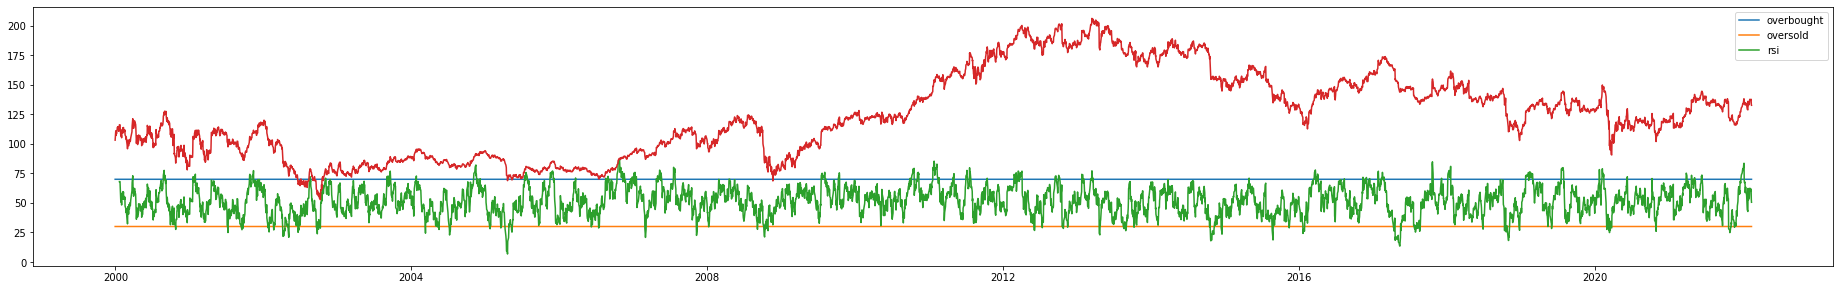

In [16]:
# RSI - Relative Strength Index

#IBM

rsi_IBM = talib.RSI(close_IBM, timeperiod=14)
IBM_final["RSI"] = rsi_IBM

mean = IBM_final["RSI"].mean()

IBM_final["RSI"]= IBM_final["RSI"].fillna(mean)

RSI_IBM = []

for i in IBM_final["RSI"]:
    if i > 70:
        RSI_IBM.append(-1)
    elif i> 30 and i< 70:
        RSI_IBM.append(0)
    elif i < 30:
        RSI_IBM.append(1)
  

IBM_final["RSI_strategy"] = RSI_IBM

fig = plt.figure()
fig.set_size_inches((25, 18))
ax_rsi = fig.add_axes((0, 0.24, 1, 0.2))
ax_rsi.plot(IBM_final.index, [70] * len(IBM_final.index), label="overbought")
ax_rsi.plot(IBM_final.index, [30] * len(IBM_final.index), label="oversold")
ax_rsi.plot(IBM_final.index, rsi_IBM, label="rsi")
ax_rsi.plot(IBM_final["Close"])
ax_rsi.legend()

#NASDAQ

rsi_NASDAQ = talib.RSI(close_NASDAQ, timeperiod=14)
NASDAQ_final["RSI"] = rsi_NASDAQ

mean = NASDAQ_final["RSI"].mean()

NASDAQ_final["RSI"]= NASDAQ_final["RSI"].fillna(mean)

RSI_NASDAQ = []

for i in NASDAQ_final["RSI"]:
    if i > 70:
        RSI_NASDAQ.append(-1)
    elif i> 30 and i< 70:
        RSI_NASDAQ.append(0)
    elif i < 30:
        RSI_NASDAQ.append(1)
  

NASDAQ_final["RSI_strategy"] = RSI_NASDAQ

#GLD

rsi_GLD = talib.RSI(close_GLD, timeperiod=14)
GLD_final["RSI"] = rsi_GLD

mean = GLD_final["RSI"].mean()

GLD_final["RSI"]= GLD_final["RSI"].fillna(mean)

RSI_GLD = []

for i in GLD_final["RSI"]:
    if i > 70:
        RSI_GLD.append(-1)
    elif i> 30 and i< 70:
        RSI_GLD.append(0)
    elif i < 30:
        RSI_GLD.append(1)
  

GLD_final["RSI_strategy"] = RSI_GLD

#WTI

rsi_WTI = talib.RSI(close_WTI, timeperiod=14)
WTI_final["RSI"] = rsi_WTI

mean = WTI_final["RSI"].mean()

WTI_final["RSI"]= WTI_final["RSI"].fillna(mean)

RSI_WTI = []

for i in WTI_final["RSI"]:
    if i > 70:
        RSI_WTI.append(-1)
    elif i> 30 and i< 70:
        RSI_WTI.append(0)
    elif i < 30:
        RSI_WTI.append(1)
  

WTI_final["RSI_strategy"] = RSI_WTI

# OBV

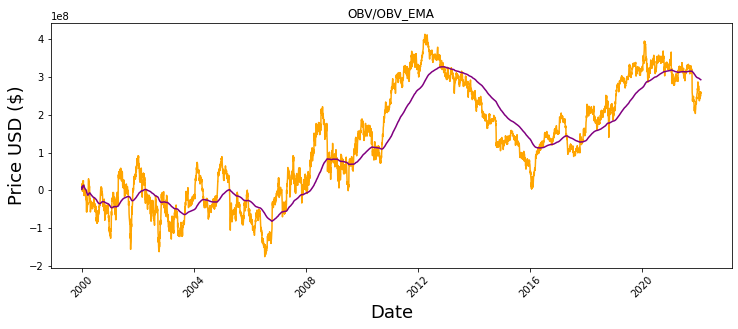

In [17]:
# OBV - On Balance Volume

#IBM

IBM_final["OBV"] = talib.OBV(close_IBM, volume_IBM)

IBM_final['OBV_EMA'] = IBM_final['OBV'].ewm(com=200).mean()

#Create and plot the graph
plt.figure(figsize=(12.2,4.5)) #width = 12.2in, height = 4.5
#plt.plot( df['Close'],  label='Close')#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.plot( IBM_final['OBV'],  label='OBV', color= 'orange')
plt.plot( IBM_final['OBV_EMA'],  label='OBV_EMA', color= 'purple')
plt.xticks(rotation=45) 
plt.title('OBV/OBV_EMA')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.show()

#if OBV > OBV EMA BUY (1) else sell (-1)
obv = IBM_final["OBV"]
obv_ema = IBM_final["OBV_EMA"]

OBV_strategy= []

for i in range(len(obv)):
    if obv[i] > obv_ema[i]:
        strategy = 1
    else:
        strategy = -1
        
    OBV_strategy.append(strategy)

IBM_final["OBV_strategy"] = OBV_strategy

# NASDAQ

NASDAQ_final["OBV"] = talib.OBV(close_NASDAQ, volume_NASDAQ)
NASDAQ_final['OBV_EMA'] = NASDAQ_final['OBV'].ewm(com=200).mean()

#if OBV > OBV EMA BUY (1) else sell (-1)

obv_NASDAQ = NASDAQ_final["OBV"]
obv_ema_NASDAQ = NASDAQ_final["OBV_EMA"]

OBV_strategy_NASDAQ= []

for i in range(len(obv_NASDAQ)):
    if obv_NASDAQ[i] > obv_ema_NASDAQ[i]:
        strategy = 1
    else:
        strategy = -1
        
    OBV_strategy_NASDAQ.append(strategy)

NASDAQ_final["OBV_strategy"] = OBV_strategy_NASDAQ

#GLD

GLD_final["OBV"] = talib.OBV(close_GLD, volume_GLD)
GLD_final['OBV_EMA'] = GLD_final['OBV'].ewm(com=200).mean()

#if OBV > OBV EMA BUY (1) else sell (-1)

obv_GLD = GLD_final["OBV"]
obv_ema_GLD = GLD_final["OBV_EMA"]

OBV_strategy_GLD= []

for i in range(len(obv_GLD)):
    if obv_GLD[i] > obv_ema_GLD[i]:
        strategy = 1
    else:
        strategy = -1
        
    OBV_strategy_GLD.append(strategy)

GLD_final["OBV_strategy"] = OBV_strategy_GLD

#WTI

WTI_final["OBV"] = talib.OBV(close_WTI, volume_WTI)
WTI_final['OBV_EMA'] = WTI_final['OBV'].ewm(com=200).mean()

#if OBV > OBV EMA BUY (1) else sell (-1)

obv_WTI = WTI_final["OBV"]
obv_ema_WTI = WTI_final["OBV_EMA"]

OBV_strategy_WTI= []

for i in range(len(obv_WTI)):
    if obv_WTI[i] > obv_ema_WTI[i]:
        strategy = 1
    else:
        strategy = -1
        
    OBV_strategy_WTI.append(strategy)

WTI_final["OBV_strategy"] = OBV_strategy_WTI



# TSF

In [18]:
# TSF - Time Series Forecast


#IBM

IBM_final["TSF"] = talib.TSF(close_IBM, timeperiod=14)

mean = IBM_final["TSF"].mean()

IBM_final["TSF"]= IBM_final["TSF"].fillna(mean)

tsf = IBM_final["TSF"]
TSF= []


for i in range(len(tsf)):
    if tsf[i] >  (close_IBM[i]*1.05):
        TSF.append(1)
    elif tsf[i] <  (close_IBM[i]*1.05) and tsf[i] >= (close_IBM[i]*0.95):
        TSF.append(0)
    elif tsf[i] <  (close_IBM[i]*0.95):
        TSF.append(-1)
   
IBM_final["TSF_strategy"] = TSF



#NASDAQ

NASDAQ_final["TSF"] = talib.TSF(close_NASDAQ, timeperiod=14)

mean =NASDAQ_final["TSF"].mean()
NASDAQ_final["TSF"]=NASDAQ_final["TSF"].fillna(mean)

tsf =NASDAQ_final["TSF"]
TSF= []


for i in range(len(tsf)):
    if tsf[i] >  (close_NASDAQ[i]*1.05):
        TSF.append(1)
    elif tsf[i] <  (close_NASDAQ[i]*1.05) and tsf[i] >= (close_NASDAQ[i]*0.95):
        TSF.append(0)
    elif tsf[i] <  (close_NASDAQ[i]*0.95):
        TSF.append(-1)

NASDAQ_final["TSF_strategy"] = TSF

#GLD

GLD_final["TSF"] = talib.TSF(close_GLD, timeperiod=14)

mean =GLD_final["TSF"].mean()
GLD_final["TSF"]=GLD_final["TSF"].fillna(mean)

tsf =GLD_final["TSF"]
TSF= []


for i in range(len(tsf)):
    if tsf[i] >  (close_GLD[i]*1.05):
        TSF.append(1)
    elif tsf[i] <  (close_GLD[i]*1.05) and tsf[i] >= (close_GLD[i]*0.95):
        TSF.append(0)
    elif tsf[i] <  (close_GLD[i]*0.95):
        TSF.append(-1)

GLD_final["TSF_strategy"] = TSF

#WTI

WTI_final["TSF"] = talib.TSF(close_WTI, timeperiod=14)

mean =WTI_final["TSF"].mean()
WTI_final["TSF"]=WTI_final["TSF"].fillna(mean)

tsf =WTI_final["TSF"]
TSF= []


for i in range(len(tsf)):
    if tsf[i] >  (close_WTI[i]*1.05):
        TSF.append(1)
    elif tsf[i] <  (close_WTI[i]*1.05) and tsf[i] >= (close_WTI[i]*0.95):
        TSF.append(0)
    elif tsf[i] <  (close_WTI[i]*0.95):
        TSF.append(-1)

WTI_final["TSF_strategy"] = TSF

# WILLR

In [19]:
# WILLR - Williams' %R

#IBM

IBM_final["WILLR"] = talib.WILLR(high_IBM, low_IBM, true_close_IBM, timeperiod=14)

mean = IBM_final["WILLR"].mean()

IBM_final["WILLR"]= IBM_final["WILLR"].fillna(mean)

WILLR = []

for i in IBM_final["WILLR"]:
    if i >= -20:
        WILLR.append(-1)
    elif i> -80 and i< -20:
        WILLR.append(0)
    elif i <= -80:
        WILLR.append(1)

IBM_final["WILLR_strategy"] = WILLR


#NASDAQ

NASDAQ_final["WILLR"] = talib.WILLR(high_NASDAQ, low_NASDAQ, true_close_NASDAQ, timeperiod=14)

mean = NASDAQ_final["WILLR"].mean()

NASDAQ_final["WILLR"]= NASDAQ_final["WILLR"].fillna(mean)

WILLR = []

for i in NASDAQ_final["WILLR"]:
    if i >= -20:
        WILLR.append(-1)
    elif i> -80 and i< -20:
        WILLR.append(0)
    elif i <= -80:
        WILLR.append(1)

NASDAQ_final["WILLR_strategy"] = WILLR

#GOLD

GLD_final["WILLR"] = talib.WILLR(high_GLD, low_GLD, true_close_GLD, timeperiod=14)

mean = GLD_final["WILLR"].mean()

GLD_final["WILLR"]= GLD_final["WILLR"].fillna(mean)

WILLR = []

for i in GLD_final["WILLR"]:
    if i >= -20:
        WILLR.append(-1)
    elif i> -80 and i< -20:
        WILLR.append(0)
    elif i <= -80:
        WILLR.append(1)

GLD_final["WILLR_strategy"] = WILLR

#WTI

WTI_final["WILLR"] = talib.WILLR(high_WTI, low_WTI, true_close_WTI, timeperiod=14)

mean = WTI_final["WILLR"].mean()

WTI_final["WILLR"]= WTI_final["WILLR"].fillna(mean)

WILLR = []

for i in WTI_final["WILLR"]:
    if i >= -20:
        WILLR.append(-1)
    elif i> -80 and i< -20:
        WILLR.append(0)
    elif i <= -80:
        WILLR.append(1)

WTI_final["WILLR_strategy"] = WILLR

# STOCH

In [ ]:
# STOCH

#IBM

stoch_K, stoch_D = talib.STOCH(high_IBM, low_IBM, true_close_IBM, fastk_period=14, slowk_period=3,  slowd_period=3)
IBM_final["STOCH_K"] = stoch_K
IBM_final["STOCH_D"] = stoch_D

IBM_stoch_k = []
IBM_stoch_d = []

for x in stoch_K:
    if x >= 80:
        IBM_stoch_k.append(-1)
    elif x <= 20:
        IBM_stoch_k.append(1)
    else:
        IBM_stoch_k.append(0)

        
IBM_final["STOCH_K_strategy"] = IBM_stoch_k



for x in stoch_D:
    if x >= 80:
        IBM_stoch_d.append(-1)
    elif x <= 20:
        IBM_stoch_d.append(1)
    else:
        IBM_stoch_d.append(0)

        
IBM_final["STOCH_D_strategy"] = IBM_stoch_d

        

#NASDAQ

stoch_K, stoch_D = talib.STOCH(high_NASDAQ, low_NASDAQ, true_close_NASDAQ, fastk_period=14, slowk_period=3,  slowd_period=3)
NASDAQ_final["STOCH_K"] = stoch_K
NASDAQ_final["STOCH_D"] = stoch_D

NASDAQ_stoch_k = []
NASDAQ_stoch_d = []

for x in stoch_K:
    if x >= 80:
        NASDAQ_stoch_k.append(-1)
    elif x <= 20:
        NASDAQ_stoch_k.append(1)
    else:
        NASDAQ_stoch_k.append(0)

        
NASDAQ_final["STOCH_K_strategy"] = NASDAQ_stoch_k



for x in stoch_D:
    if x >= 80:
        NASDAQ_stoch_d.append(-1)
    elif x <= 20:
        NASDAQ_stoch_d.append(1)
    else:
        NASDAQ_stoch_d.append(0)

        
NASDAQ_final["STOCH_D_strategy"] = NASDAQ_stoch_d

        

#GOLD

stoch_K, stoch_D = talib.STOCH(high_GLD, low_GLD, true_close_GLD, fastk_period=14, slowk_period=3,  slowd_period=3)
GLD_final["STOCH_K"] = stoch_K
GLD_final["STOCH_D"] = stoch_D

GLD_stoch_k = []
GLD_stoch_d = []

for x in stoch_K:
    if x >= 80:
        GLD_stoch_k.append(-1)
    elif x <= 20:
        GLD_stoch_k.append(1)
    else:
        GLD_stoch_k.append(0)

        
GLD_final["STOCH_K_strategy"] = GLD_stoch_k



for x in stoch_D:
    if x >= 80:
        GLD_stoch_d.append(-1)
    elif x <= 20:
        GLD_stoch_d.append(1)
    else:
        GLD_stoch_d.append(0)

        
GLD_final["STOCH_D_strategy"] = GLD_stoch_d

        

#WTI

stoch_K, stoch_D = talib.STOCH(high_WTI, low_WTI, true_close_WTI, fastk_period=14, slowk_period=3,  slowd_period=3)
WTI_final["STOCH_K"] = stoch_K
WTI_final["STOCH_D"] = stoch_D

WTI_stoch_k = []
WTI_stoch_d = []

for x in stoch_K:
    if x >= 80:
        WTI_stoch_k.append(-1)
    elif x <= 20:
        WTI_stoch_k.append(1)
    else:
        WTI_stoch_k.append(0)

        
WTI_final["STOCH_K_strategy"] = WTI_stoch_k



for x in stoch_D:
    if x >= 80:
        WTI_stoch_d.append(-1)
    elif x <= 20:
        WTI_stoch_d.append(1)
    else:
        WTI_stoch_d.append(0)

        
WTI_final["STOCH_D_strategy"] = WTI_stoch_d

        

# STOCH D (window = 4), K(window = 3)

In [23]:
# STOCH D(window = 4), K(window = 3)

def stok(df, n):
    df["stok"] = ((df["Close"] - df["Low"].rolling(window = n, center = False).mean()) /
                  (df["High"].rolling(window = n, center = False).max() -
                  df["Low"].rolling(window = n, center = False).min())) *100
    df["stod"] = df["stok"].rolling(window = 3, center = False).mean()

stok(IBM_final, 4)
IBM_final = IBM_final.fillna(0)

stok(NASDAQ_final, 4)
NASDAQ_final = NASDAQ_final.fillna(0)

stok(WTI_final, 4)
WTI_final = WTI_final.fillna(0)

stok(GLD_final, 4)
GLD_final = GLD_final.fillna(0)

#ROC

IBM_final["ROC"] = talib.ROC(close_IBM, timeperiod = 12)
NASDAQ["ROC"] = talib.ROC(close_NASDAQ, timeperiod = 12)
WTI["ROC"] = talib.ROC(close_WTI, timeperiod = 12)
GLD["ROC"] = talib.ROC(close_GLD, timeperiod = 12)

#CCI

IBM_final["CCI"] = talib.CCI(high_IBM, low_IBM, true_close_IBM, timeperiod=20)
NASDAQ_final["CCI"] = talib.CCI(high_NASDAQ, low_NASDAQ, true_close_NASDAQ, timeperiod=20)
WTI_final["CCI"] = talib.CCI(high_WTI, low_WTI, true_close_WTI, timeperiod=20)
GLD_final["CCI"] = talib.CCI(high_GLD, low_GLD, true_close_GLD, timeperiod=20)



# EMA & TEMA

In [22]:
# EMA & TEMA

#IBM

IBM_final["EMA"] = IBM_final.AdjClose.ewm(span = 3, min_periods =0, adjust= True, ignore_na = False).mean()
IBM_final["TEMA"] = (3* IBM_final.EMA - 3 * IBM_final.EMA * IBM_final.EMA) + (IBM_final.EMA * IBM_final.EMA* IBM_final.EMA)

#NASDAQ

NASDAQ_final["EMA"] = NASDAQ_final.AdjClose.ewm(span = 3, min_periods =0, adjust= True, ignore_na = False).mean()
NASDAQ_final["TEMA"] = (3* NASDAQ_final.EMA - 3 * NASDAQ_final.EMA * NASDAQ_final.EMA) + (NASDAQ_final.EMA * NASDAQ_final.EMA* NASDAQ_final.EMA)

#WTI

WTI_final["EMA"] = WTI_final.AdjClose.ewm(span = 3, min_periods =0, adjust= True, ignore_na = False).mean()
WTI_final["TEMA"] = (3* WTI_final.EMA - 3 * WTI_final.EMA * WTI_final.EMA) + (WTI_final.EMA * WTI_final.EMA* WTI_final.EMA)

#GOLD

GLD_final["EMA"] = GLD_final.AdjClose.ewm(span = 3, min_periods =0, adjust= True, ignore_na = False).mean()
GLD_final["TEMA"] = (3* GLD_final.EMA - 3 * GLD_final.EMA * GLD_final.EMA) + (GLD_final.EMA * GLD_final.EMA* GLD_final.EMA)

# BOLLINGER BANDS

In [21]:
# BOLLINGER WINDOW 21G STD 2

#IBM

upperband, middleband, lowerband = talib.BBANDS(close_IBM, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
IBM_final["upperband"] = upperband
IBM_final["middleband"] = middleband
IBM_final["lowerband"] = lowerband

#NASDAQ

upperband, middleband, lowerband = talib.BBANDS(close_NASDAQ, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
NASDAQ_final["upperband"] = upperband
NASDAQ_final["middleband"] = middleband
NASDAQ_final["lowerband"] = lowerband

#WTI

upperband, middleband, lowerband = talib.BBANDS(close_WTI, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
WTI_final["upperband"] = upperband
WTI_final["middleband"] = middleband
WTI_final["lowerband"] = lowerband

#GOLD

upperband, middleband, lowerband = talib.BBANDS(close_GLD, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
GLD_final["upperband"] = upperband
GLD_final["middleband"] = middleband
GLD_final["lowerband"] = lowerband

# MOM


In [30]:
#MOM

IBM_final["MOM"] = IBM_final.AdjClose - 1
NASDAQ_final["MOM"] = NASDAQ_final.AdjClose - 1
WTI_final["MOM"] = WTI_final.AdjClose - 1
GLD_final["MOM"] = GLD_final.AdjClose - 1


In [29]:
IBM_final.to_excel('IBM_final.xlsx')
NASDAQ_final.to_excel('NASDAQ_final.xlsx')
GLD_final.to_excel('GDL_final.xlsx')
WTI_final.to_excel('WTI_final.xlsx')